# The Fundamentals of Autograd

## What do we need Autograd for?

Treating inputs as n *i*-dimensional vector $\vec{x}$, model *M* can be expressed as vector-valued function $\vec{y} = \vec{M}(\vec{x})$. From here, the vector sign is omitted where contextually clear.

Since mostly discussing autograd in context of training, output of interest is model's loss function $L(\vec{y}) = L(\vec{M}(\vec{x}))$, a single-valued scalar function of model output expressing how far off model's prediction was from particular input's *ideal* output.

Minimising loss involves iteratively nudging learning weights until tolerable loss produced for variety of inputs.

This means making $\frac{\partial L}{\partial x} = 0$, which should be re-expressed to be derived from a funciton of the model output $\frac{\partial L(\vec{y})}{\partial x} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial x} = \frac{\partial L}{\partial y} \frac{\partial M(x)}{\partial x}$.

Across many local partial derivatives within $\frac{\partial M(x)}{\partial x}$, gradients over learning weights most of interest - tell us *what direction to change each weight* to get loss function closer to zero.

Since number of local derivates (each corresponding to separate path through model's computation graph) goes up exponentially with network depth, so does comlexity in computing them. Autograd tracks history of every computation, greatly speeding up learning.

## A Simple Example

In [3]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch

In [ ]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
# In every computation that follows, autograd will accum history of computation in output tensors

print(a)

In [ ]:
b = torch.sin(a)
plt.plot(a.detach(), b.detach())

In [ ]:
print(b) 
# grad_fn hints that executing back-prop step, will need to
# compute derivative of sin(x) for all this this tensor's inpurts

In [ ]:
c = 2*b
print(c)

d = c+1
print(d)

In [ ]:
# Single-element output, as would be needed to call .backward() on tensor w/o args
out = d.sum()
print(out)

In [7]:
# Each grad_fn stored allows walking down computation to inputs with `next_functions` property

print("d:")
print(d.grad_fn)
print(d.grad_fn.next_functions)
print(d.grad_fn.next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)

print("\nc:")
print(c.grad_fn)

print("\nb:")
print(b.grad_fn)

print("\na:")
print(a.grad_fn)

d:
((<MulBackward0 object at 0x0000023CEDCD3640>, 0), (None, 0))
((<SinBackward0 object at 0x0000023CEDBC53A0>, 0), (None, 0))
((<AccumulateGrad object at 0x0000023CEDCD3580>, 0),)
()

c:

b:

a:
None


tensor([ 2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,  1.0000e+00,
         5.1764e-01, -8.7423e-08, -5.1764e-01, -1.0000e+00, -1.4142e+00,
        -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00, -1.7321e+00,
        -1.4142e+00, -1.0000e+00, -5.1764e-01,  2.3850e-08,  5.1764e-01,
         1.0000e+00,  1.4142e+00,  1.7321e+00,  1.9319e+00,  2.0000e+00])


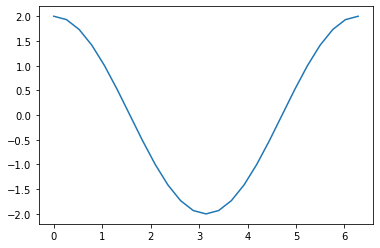

In [8]:
# Get derivates out

out.backward()
print(a.grad)
plt.plot(a.detach(), a.grad.detach())

In [9]:
# Cmoputation steps taken to get here

a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
b = torch.sin(a)
c = 2 * b
d = c + 1
out = d.sum()

Only compuation's *leaf nodes* have gradients computed. `print(c.grad)` would return `None`. Here only input is leaf node.

## Autograd in Training

In [10]:
BATCH_SIZE = 16
DIM_IN = 1000
HIDDEN_SIZE = 100
DIM_OUT = 10

class TinyModel(torch.nn.Module):
    def __init__(self):
        super(TinyModel, self).__init__()

        # No need to specify autograd because assumed true in nn.Module subclass
        self.layer1 = torch.nn.Linear(1000, 100)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(100, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        
        return x

some_input = torch.randn(BATCH_SIZE, DIM_IN, requires_grad=False)
ideal_output = torch.randn(BATCH_SIZE, DIM_OUT, requires_grad=False)

model = TinyModel()

In [11]:
# Examine weights and verify no gradients computed yet

print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad)

tensor([ 0.0462,  0.0134,  0.0492, -0.0561,  0.0096,  0.0521,  0.0900,  0.0649,
        -0.0899, -0.0258], grad_fn=<SliceBackward0>)
None


In [12]:
# Run through one training batch

optimiser = torch.optim.SGD(model.parameters(), lr=0.001)

prediction = model(some_input)

loss = (ideal_output - prediction).pow(2).sum()
print(loss)

tensor(166.5551, grad_fn=<SumBackward0>)


In [13]:
loss.backward()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([ 0.0462,  0.0134,  0.0492, -0.0561,  0.0096,  0.0521,  0.0900,  0.0649,
        -0.0899, -0.0258], grad_fn=<SliceBackward0>)
tensor([-0.9128, -1.3424,  1.2112,  0.3252, -1.3144,  0.0086, -3.2288,  0.5864,
        -1.2520,  0.2413])


In [14]:
# Gradients computed for each weight but weights not changed because haven't run optimiser yet

optimiser.step()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([ 0.0471,  0.0148,  0.0480, -0.0564,  0.0109,  0.0521,  0.0932,  0.0644,
        -0.0886, -0.0260], grad_fn=<SliceBackward0>)
tensor([-0.9128, -1.3424,  1.2112,  0.3252, -1.3144,  0.0086, -3.2288,  0.5864,
        -1.2520,  0.2413])


In [15]:
# After running optimiser.step(), need to call optimiser.zero_grad() to
# stop acummuclating grad on learning weights after every loss.backward()

# Example of not doing this
print(model.layer2.weight.grad[0][0:10])

for i in range(5):
    pred = model(some_input)
    loss = (ideal_output - pred).pow(2).sum()
    loss.backward()

print(model.layer2.weight.grad[0][0:10])  # gradient magnitudes much larger

optimiser.zero_grad()

print(model.layer2.weight.grad[0][0:10])

tensor([-0.9128, -1.3424,  1.2112,  0.3252, -1.3144,  0.0086, -3.2288,  0.5864,
        -1.2520,  0.2413])
tensor([ -8.2824,  -5.8159,  -1.7837,   5.9662,  -4.6105,   2.1204, -14.6650,
          7.2954,   2.2307,  -2.4608])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


## Turning Autograd Off and On

In [17]:
# Simplest: require_grad

a = torch.ones(2, 3, requires_grad=True)
print(a)

b1 = 2 * a
print(b1)

a.requires_grad = False
b2 = 2 * a
print(b2)

tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)
tensor([[2., 2., 2.],
        [2., 2., 2.]], grad_fn=<MulBackward0>)
tensor([[2., 2., 2.],
        [2., 2., 2.]])


In [18]:
# Temporary: torch.no_grad()

a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = a + b
print(c1)

with torch.no_grad():
    c2 = a + b

print(c2)

c3 = a * b
print(c3)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])
tensor([[6., 6., 6.],
        [6., 6., 6.]], grad_fn=<MulBackward0>)


In [19]:
# torch.no_grad() used as func/method decorator:

def add_tensors1(x, y):
    return x + y

@torch.no_grad()
def add_tensors2(x, y):
    return x + y


a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = add_tensors1(a, b)
print(c1)

c2 = add_tensors2(a, b)
print(c2)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])


In [25]:
# Have tensor that needs grad tracking but want copy that doesn't

x = torch.rand(5, requires_grad=True)
y = x.detach()

print(x)
print(y)

tensor([0.8464, 0.7784, 0.8706, 0.0292, 0.1628], requires_grad=True)
tensor([0.8464, 0.7784, 0.8706, 0.0292, 0.1628])


### Autograd and In-place Operations

In every example in this notebook so far, we’ve used variables to capture the intermediate values of a computation. Autograd needs these intermediate values to perform gradient computations. *For this reason, you must be careful about using in-place operations when using autograd.* Doing so can destroy information you need to compute derivatives in the `backward()` call. PyTorch will even stop you if you attempt an in-place operation on leaf variable that requires autograd, as shown below.

In [26]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)

try:
    torch.sin_(a)
except RuntimeError as err:
    print(err)

a leaf Variable that requires grad is being used in an in-place operation.


## Autograd Profiler

Autograd's computation tracking plus timing information would make a handy profiler.

In [27]:
x = torch.randn(2, 3, requires_grad=True)
y = torch.rand(2, 3, requires_grad=True)
z = torch.ones(2, 3, requires_grad=True)

with torch.autograd.profiler.profile() as prf:
    for _ in range(1000):
        z = (z/x)*y

print(prf.key_averages().table(sort_by="self_cpu_time_total"))

-------------  ------------  ------------  ------------  ------------  ------------  ------------  
         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------  ------------  ------------  ------------  ------------  ------------  ------------  
    aten::div        66.46%      10.941ms        66.46%      10.941ms      10.941us          1000  
    aten::mul        33.54%       5.522ms        33.54%       5.522ms       5.522us          1000  
-------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 16.463ms



## More Autograd Detail and the High-Level API

Imagine PyTorch model as function with n-dimensional input and m-dimensional output $\vec{y} = f(\vec{x})$ and jacobian $J$.

Loss function $l = g(\vec{y})$ that returns a scalar output would have gradients as column vector $v = \Big(\frac{\partial l}{\partial y_1} \cdots \frac{\partial l}{\partial y_m}\Big)^T$.

$$v^T \cdot J = \Bigg(\frac{\partial l}{\partial y_1} \cdots \frac{\partial l}{\partial y_m}\Bigg) \cdot \underline{J} = \Bigg(\frac{\partial l}{\partial x_1} \cdots \frac{\partial l}{\partial x_n}\Bigg)$$

**`torch.autograd` computes these (Jacobian-vector) products,** and is how gradients over learning weights are accumulated during backward pass.

`backward()` call can also take optional vector input representing set of gradients over (output) tensor, which are multiplied by Jacobian of autograd-traced tensor preceding it.

In [7]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

tensor([ 571.7303, 1491.2374,   28.9516], grad_fn=<MulBackward0>)


In [9]:
try:
    y.backward()
except RuntimeError as err:
    # For multi-dim output, need to provide their
    # gradients for autograd to multiply into Jacobian
    print(err)

v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float) # stand-in for gradients
y.backward(v)

print(x.grad)

grad can be implicitly created only for scalar outputs
tensor([5.1200e+01, 5.1200e+02, 5.1200e-02])


### The High-Level API

There is API on autograd that gives direct access to important differentiqal matrix and vector ops, notably calculating Jacobian and Hessian of particular function and inputs.

In [17]:
def exp_adder(x, y):
    return 2 * x.exp() + 3 * y

inputs = (torch.rand(1), torch.rand(1))  # function args
print("  Inputs:", inputs)

print("Jacobian:", torch.autograd.functional.jacobian(exp_adder, inputs))  # 2e^x and 3
print(" Hessian:", torch.autograd.functional.hessian(exp_adder, inputs))

  Inputs: (tensor([0.9878]), tensor([0.0714]))
Jacobian: (tensor([[5.3709]]), tensor([[3.]]))
 Hessian: ((tensor([[5.3709]]), tensor([[0.]])), (tensor([[0.]]), tensor([[0.]])))


In [18]:
# Directly computing vector-Jacobian product, if vector provided

def do_some_doubling(x):
    y = x*2
    while y.data.norm() < 1000:
        y *= 2
    return y

inputs = torch.rand(3)
grads = torch.tensor([0.1, 1.0, 0.0001])
torch.autograd.functional.vjp(do_some_doubling, inputs, grads)  # jvp() same with operands reversed
# vhp() and hvp() also exist

(tensor([514.8537, 653.6339, 811.2714]),
 tensor([1.0240e+02, 1.0240e+03, 1.0240e-01]))